<a href="https://colab.research.google.com/github/Haadi-kp/Image_Colourization/blob/main/Colab_Notebooks/Open_cv_test_31_12_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the destination folder if it doesn't exist
!mkdir -p /content/datas



In [ ]:

# Unzip files into the 'datas' folder
!unzip /content/drive/MyDrive/image_colouring/Places365.zip -d /content/datas


Streaming output truncated to the last 5000 lines.
  inflating: /content/datas/stage-indoor/Places365_val_00000779.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00001098.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00001251.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00001327.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00002052.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00002158.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00002574.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00003094.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00003171.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00005187.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00005920.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00006640.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00006762.jpg  
  inflating: /content/datas/stage-indoo

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
import os
from tensorflow import keras
from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.applications import InceptionV3
import cv2


# Batch size for training
batch_size = 64

# Size of the image required to train our model
img_size = 120

# Define the maximum number of folders and images to process
max_folders = 100  # Use only 50 folders
images_per_folder = 35  # Use only 50 images per folder

master_dir = '/content/datas'
x = []
y = []

# Get and sort folder names
all_folders = sorted([folder for folder in os.listdir(master_dir) if os.path.isdir(os.path.join(master_dir, folder))])


In [ ]:
processed_folders = 0

for folder_name in all_folders[:max_folders]:
    folder_path = os.path.join(master_dir, folder_name)
    print(f"{processed_folders + 1}: Processing folder: {folder_name}")

    processed_images = 0  # Counter to track processed images in the folder
    for image_file in os.listdir(folder_path):
        if processed_images >= images_per_folder:  # Stop after a certain number of images
            break
        image_path = os.path.join(folder_path, image_file)
        try:
            # Load the image using OpenCV
            image = cv2.imread(image_path)

            # Resize the image to the required size
            resized_image = cv2.resize(image, (img_size, img_size))

            # Convert the image to Lab color space
            lab_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2Lab)

            # Split Lab channels
            l_channel, a_channel, b_channel = cv2.split(lab_image)

            # Normalize L channel to [0, 1]
            l_channel = l_channel / 100.0

            # Normalize a and b channels to [-1, 1]
            a_channel = (a_channel - 128) / 128.0
            b_channel = (b_channel - 128) / 128.0

            # Append L and ab arrays
            x.append(l_channel.reshape((img_size, img_size, 1)))  # Add channel dimension for L
            y.append(np.stack([a_channel, b_channel], axis=-1))  # Stack a, b channels

            processed_images += 1  # Increment the image counter
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    processed_folders += 1  # Increment the folder counter

# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split(np.array(x), np.array(y), test_size=0.1)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)


1: Processing folder: airfield
2: Processing folder: airplane_cabin
3: Processing folder: airport_terminal
4: Processing folder: alcove
5: Processing folder: alley
6: Processing folder: amphitheater
7: Processing folder: amusement_arcade
8: Processing folder: amusement_park
9: Processing folder: apartment_building-outdoor
10: Processing folder: aquarium
11: Processing folder: aqueduct
12: Processing folder: arcade
13: Processing folder: arch
14: Processing folder: archaelogical_excavation
15: Processing folder: archive
16: Processing folder: arena-hockey
17: Processing folder: arena-performance
18: Processing folder: arena-rodeo
19: Processing folder: army_base
20: Processing folder: art_gallery
21: Processing folder: art_school
22: Processing folder: art_studio
23: Processing folder: artists_loft
24: Processing folder: assembly_line
25: Processing folder: athletic_field-outdoor
26: Processing folder: atrium-public
27: Processing folder: attic
28: Processing folder: auditorium
29: Proc

In [ ]:
def get_generator_model():
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 1))

    # Downsampling layers
    conv1 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1)(inputs)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)

    conv2 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1)(conv1)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)

    conv3 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1)(conv2)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)

    # Bottleneck layer
    bottleneck = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='tanh', padding='same')(conv3)

    # Upsampling layers
    concat_1 = tf.keras.layers.Concatenate()([bottleneck, conv3])
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, activation='relu')(concat_1)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_3)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_3)

    concat_2 = tf.keras.layers.Concatenate()([conv_up_3, conv2])
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation='relu')(concat_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_2)

    concat_3 = tf.keras.layers.Concatenate()([conv_up_2, conv1])
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation='relu')(concat_3)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_1)

    # Output layer to produce a and b channels for Lab
    conv_up_1 = tf.keras.layers.Conv2DTranspose(2, kernel_size=(5, 5), strides=1, activation='tanh')(conv_up_1)

    # Define model
    model = tf.keras.models.Model(inputs, conv_up_1)
    return model


In [ ]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides=1, activation='relu', input_shape=(120, 120, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
    model = tf.keras.models.Sequential(layers)
    return model


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    # Real output loss
    real_loss = cross_entropy(
        tf.ones_like(real_output) - tf.random.uniform(shape=real_output.shape, maxval=0.1),
        real_output,
    )
    # Fake output loss
    fake_loss = cross_entropy(
        tf.zeros_like(fake_output) + tf.random.uniform(shape=fake_output.shape, maxval=0.1),
        fake_output,
    )
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output, real_ab):
    """
    fake_output: Predicted a, b channels from the generator (batch_size, height, width, 2)
    real_ab: Ground truth a, b channels (batch_size, height, width, 2)
    """
    # Compare the generated a, b channels with the ground truth
    real_ab = tf.cast(real_ab, 'float32')
    return mse(fake_output, real_ab)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(0.0005)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0005)

# Models
generator = get_generator_model()  # Outputs a, b channels
discriminator = get_discriminator_model()  # Accepts Lab images or a+b concatenated


In [ ]:
@tf.function
def train_step(input_x, real_ab):
    """
    input_x: L channel of the input image (batch_size, height, width, 1)
    real_ab: Ground truth a and b channels (batch_size, height, width, 2)
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate a, b channels from the generator
        generated_ab = generator(input_x, training=True)

        # Cast input_x to float32 to match the generator's output
        input_x = tf.cast(input_x, tf.float32)

        # Cast real_ab to float32 to match input_x
        real_ab = tf.cast(real_ab, tf.float32)

        # Combine L with generated a, b to form a complete Lab image
        generated_lab = tf.concat([input_x, generated_ab], axis=-1)

        # Combine L with real a, b to form a complete Lab image
        real_lab = tf.concat([input_x, real_ab], axis=-1)

        # Discriminator output for real and generated Lab images
        # Change the input shape of the first layer in the discriminator model to (120, 120, 4)
        discriminator.layers[0]._batch_input_shape = (None, 120, 120, 4) # Change here to input (120, 120, 4) which is L, a, b

        real_output = discriminator(real_lab, training=True)
        generated_output = discriminator(generated_lab, training=True)

        # Generator loss: Compare generated a, b with real a, b
        gen_loss = generator_loss(generated_ab, real_ab)

        # Discriminator loss: Distinguish between real and generated Lab images
        disc_loss = discriminator_loss(real_output, generated_output)

    # Compute gradients for the generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    iteration = 0  # Counter for iterations

    # Iterate through the dataset
    for input_x, real_y in dataset:
        # Perform a training step
        gen_loss, disc_loss = train_step(input_x, real_y)

        # Log every 20th iteration
        if iteration % 10 == 0:
            print(f"Iteration {iteration}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")
        iteration += 1

Epoch 1/100
Iteration 0, Generator Loss: 1.1881, Discriminator Loss: 1.3851
Iteration 10, Generator Loss: 0.8472, Discriminator Loss: 0.9751
Iteration 20, Generator Loss: 0.8081, Discriminator Loss: 0.8908
Iteration 30, Generator Loss: 0.7704, Discriminator Loss: 0.4439
Iteration 40, Generator Loss: 0.7495, Discriminator Loss: 0.4540
Epoch 2/100
Iteration 0, Generator Loss: 0.7480, Discriminator Loss: 0.8156
Iteration 10, Generator Loss: 0.7985, Discriminator Loss: 0.4617
Iteration 20, Generator Loss: 0.7674, Discriminator Loss: 0.3977
Iteration 30, Generator Loss: 0.7433, Discriminator Loss: 0.3974
Iteration 40, Generator Loss: 0.7365, Discriminator Loss: 0.4329
Epoch 3/100
Iteration 0, Generator Loss: 0.7416, Discriminator Loss: 0.4081
Iteration 10, Generator Loss: 0.7921, Discriminator Loss: 0.4044
Iteration 20, Generator Loss: 0.7636, Discriminator Loss: 0.3999
Iteration 30, Generator Loss: 0.7402, Discriminator Loss: 0.4099
Iteration 40, Generator Loss: 0.7343, Discriminator Loss:

In [ ]:
# Save the generator model to a single HDF5 file
generator_file_path = '/content/drive/MyDrive/saved_model/Lab4:generator_model.h5'
generator.save(generator_file_path)
print(f"Generator model saved to {generator_file_path}")

# Save the discriminator model to a single HDF5 file
discriminator_file_path = '/content/drive/MyDrive/saved_model/Lab4:discriminator_model.h5'
discriminator.save(discriminator_file_path)
print(f"Discriminator model saved to {discriminator_file_path}")



Generator model saved to /content/drive/MyDrive/saved_model/Lab4:generator_model.h5
Discriminator model saved to /content/drive/MyDrive/saved_model/Lab4:discriminator_model.h5


In [ ]:
from io import BytesIO
from skimage.color import lab2rgb
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib



In [ ]:


# Updated function with optional Lab conversion
def process_image_from_url(url, target_size=(120, 120), return_lab=False):
    response = requests.get(url)
    if response.status_code == 200:
        # Open the image from the response
        image = Image.open(BytesIO(response.content)).convert("L")  # Convert to grayscale
        # Resize to the model's expected input size
        image = image.resize(target_size)
        # Normalize the image
        l_channel = np.asarray(image) / 255.0  # L channel normalized
        l_channel = l_channel.reshape(1, target_size[0], target_size[1], 1)

        if return_lab:
            return l_channel, np.zeros_like(l_channel), np.zeros_like(l_channel)  # Placeholder for a, b
        return l_channel
    else:
        raise Exception(f"Failed to fetch image from URL: {response.status_code}")


# List of image URLs
image_urls = [
    "https://images.pexels.com/photos/346529/pexels-photo-346529.jpeg?cs=srgb&dl=pexels-bri-schneiter-28802-346529.jpg&fm=jpg",
    "https://media.istockphoto.com/id/517188688/photo/mountain-landscape.jpg?s=612x612&w=0&k=20&c=A63koPKaCyIwQWOTFBRWXj_PwCrR4cEoOw2S9Q7yVl8=",
    "https://images.ctfassets.net/hrltx12pl8hq/28ECAQiPJZ78hxatLTa7Ts/2f695d869736ae3b0de3e56ceaca3958/free-nature-images.jpg?fit=fill&w=1200&h=630",
    "https://plus.unsplash.com/premium_photo-1664474619075-644dd191935f?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8aW1hZ2V8ZW58MHx8MHx8fDA%3D"
    # Add more image URLs here
]


<ipython-input-21-96a940b4eb11>:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4088 negative Z values that have been clipped to zero
  colorized_image = lab2rgb(lab_image)


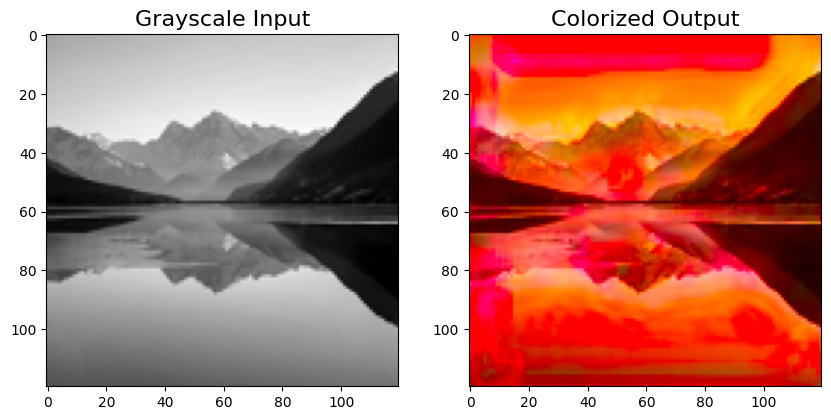

<ipython-input-21-96a940b4eb11>:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1520 negative Z values that have been clipped to zero
  colorized_image = lab2rgb(lab_image)


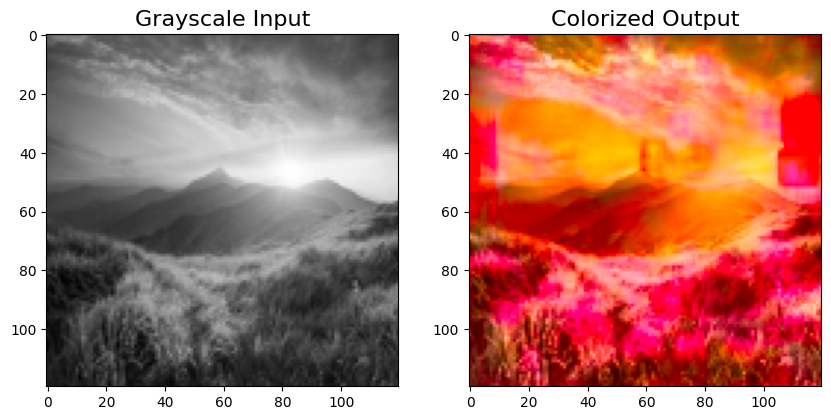

<ipython-input-21-96a940b4eb11>:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 519 negative Z values that have been clipped to zero
  colorized_image = lab2rgb(lab_image)


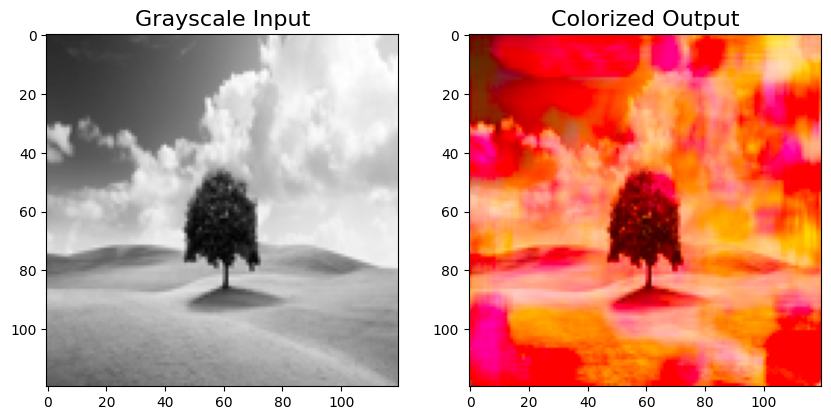

<ipython-input-21-96a940b4eb11>:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 451 negative Z values that have been clipped to zero
  colorized_image = lab2rgb(lab_image)


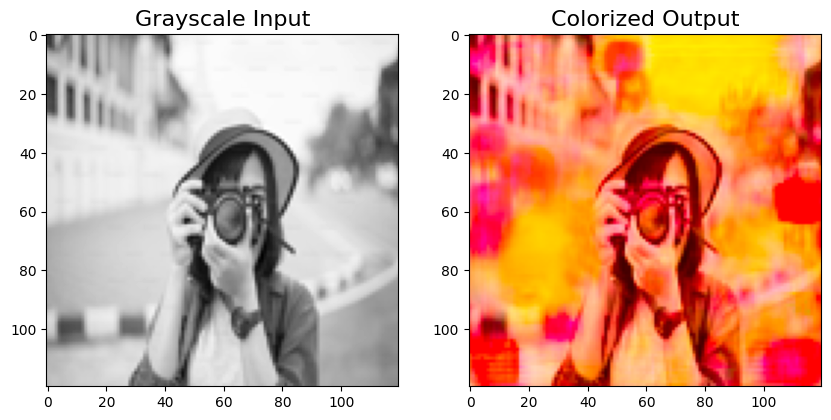

In [ ]:
for i, url in enumerate(image_urls):
    try:
        # Step 1: Preprocess the grayscale image
        test_image = process_image_from_url(url)
        gray_image = test_image[0, :, :, 0]

        # OpenCV filtering for noise removal with reduced intensity
        denoised_image = cv2.fastNlMeansDenoising((gray_image * 255).astype('uint8'), h=2)

        # Optional: Adjust contrast using CLAHE (adaptive histogram equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_gray_image = clahe.apply(denoised_image)

        # Normalize back to [0, 1]
        l_channel = enhanced_gray_image / 255.0

        # Step 2: Colorize the image
        ab_channels = generator(test_image).numpy()

        # Smooth the AB channels to avoid exaggerated colors
        ab_channels = np.clip(ab_channels, -1, 1)

        # Create Lab image and combine L with AB channels
        lab_image = np.zeros((120, 120, 3))
        lab_image[:, :, 0] = l_channel * 100  # Scale L channel to [0, 100]
        lab_image[:, :, 1:] = ab_channels[0] * 128  # Scale AB channels to [-128, 127]

        # Convert Lab to RGB
        colorized_image = lab2rgb(lab_image)

        # # Apply a small Gaussian blur to soften the image
        # colorized_image = cv2.GaussianBlur(colorized_image, (3, 3), 0)

        # Step 3: Visualization
        plt.figure(figsize=(10, 10))

        # Grayscale Input
        plt.subplot(1, 2, 1)
        plt.title('Grayscale Input', fontsize=16)
        plt.imshow(test_image[0].reshape((120, 120)), cmap='gray')

        # Colorized Output
        plt.subplot(1, 2, 2)
        plt.title('Colorized Output', fontsize=16)
        plt.imshow(colorized_image)

        plt.show()

    except Exception as e:
        print(f"Error processing image {i + 1}: {e}")


In [ ]:
for i in range(len(test_x)):
    if i % 50 == 0:
        plt.figure(figsize=(10, 10))

        # Grayscale Input (L channel)
        or_image = plt.subplot(3, 3, 1)
        or_image.set_title('Grayscale Input', fontsize=16)
        plt.imshow(test_x[i].reshape((120, 120)), cmap='gray')

        # Colorized Output (Generated a and b channels)
        in_image = plt.subplot(3, 3, 2)
        l_channel = (test_x[i].reshape((120, 120)) * 100.0).astype('float32')  # Scale L to [0, 100]
        ab_channels = (y[i] * 128.0).astype('float32')  # Scale a, b to [-128, 127]
        lab_image = cv2.merge([l_channel, ab_channels[..., 0], ab_channels[..., 1]])  # Combine L, a, b
        rgb_image = cv2.cvtColor(lab_image.astype('uint8'), cv2.COLOR_Lab2RGB)  # Convert to RGB
        image = Image.fromarray(rgb_image).resize((1024, 1024))
        in_image.set_title('Colorized Output', fontsize=16)
        plt.imshow(image)

        # Ground Truth (a and b channels from test_y)
        ou_image = plt.subplot(3, 3, 3)
        l_channel_gt = (test_x[i].reshape((120, 120)) * 100.0).astype('float32')  # Use the same L channel for ground truth
        ab_channels_gt = (test_y[i] * 128.0).astype('float32')  # Scale a, b to [-128, 127]
        lab_image_gt = cv2.merge([l_channel_gt, ab_channels_gt[..., 0], ab_channels_gt[..., 1]])  # Combine L, a, b
        rgb_image_gt = cv2.cvtColor(lab_image_gt.astype('uint8'), cv2.COLOR_Lab2RGB)  # Convert to RGB
        image_gt = Image.fromarray(rgb_image_gt).resize((1024, 1024))
        ou_image.set_title('Ground Truth', fontsize=16)
        plt.imshow(image_gt)

        plt.show()
